# objective
train a no noise Kalman filter, okay
we expect to get rid of the noisy offsets



In [1]:
import numpy as np
from riglib.bmi import accumulator, assist, bmi, clda, extractor, feedback_controllers, goal_calculators, robot_arms, sim_neurons, kfdecoder, ppfdecoder, state_space_models, train
from riglib.bmi.sim_neurons import KalmanEncoder

# start simulation

## gen test data
this code essentially exerpt from simulation_features.py

For the linear stochastic state-space model 
            x_{t+1} = Ax_{t} + Bu_t + w_t;   w_t ~ N(0, W),
        this function specifies the matrices A, B and W

        A = [I_N    \Delta I_N   0
             0_N    a*I_N        0
             0      0            1]

        W = [0_N    0_N   0
             0_N    w*I_N        0
             0      0            0]

        B = [0_N
            1000\Delta I_N
            0]

In [2]:
# generate state

from riglib.bmi.state_space_models import StateSpaceEndptVel2D
ssm = StateSpaceEndptVel2D()


n_samples = 2000

#W = np.identity(N_STATES)
#W = np.zeros((N_STATES,N_STATES))
A, _, W = ssm.get_ssm_matrices()

mean = np.zeros(A.shape[0])
mean[-1] = 1
state_samples = np.random.multivariate_normal(mean, W, n_samples)

state_samples
state_samples.shape

(2000, 7)

## set up encoder

In [3]:
N_NEURONS = 4
N_STATES = 7  # 3 positions and 3 velocities and an offset
# build the observation matrix
sim_C = np.zeros((N_NEURONS, N_STATES))
# control x positive directions
sim_C[0, :] = np.array([0, 0, 0, 1, 0, 0, 0])
sim_C[1, :] = np.array([0, 0, 0, -1, 0, 0, 0])
# control z positive directions
sim_C[2, :] = np.array([0, 0, 0, 0, 0, 1, 0])
sim_C[3, :] = np.array([0, 0, 0, 0, 0, -1, 0])


In [4]:
from riglib.bmi.sim_neurons import GenericCosEnc#CLDASimCosEnc

print('SimCosineTunedEnc SSM:', ssm)
encoder = GenericCosEnc(sim_C, 
                         ssm, 
                         return_ts=True, 
                         DT=0.1, 
                         call_ds_rate=6)
encoder.call_ds_rate = 1
sim_C.shape

SimCosineTunedEnc SSM: State space: ['hand_px', 'hand_py', 'hand_pz', 'hand_vx', 'hand_vy', 'hand_vz', 'offset']


(4, 7)

## train the decoder as if we are begining a new BCI

In [5]:
n_units = sim_C.shape[0]
spike_counts = np.zeros([n_units, n_samples])

for k in range(n_samples):
    spike_counts[:,k] = np.array(encoder(state_samples[k],
                                              mode='counts')).ravel()

kin = state_samples.T
trained_decoder = train.train_KFDecoder_abstract(ssm, 
                                              kin, 
                                              spike_counts, 
                                              encoder.get_units(), 
                                              0.1, 
                                              zscore=False)
trained_decoder.filt.C

{}
end of kwargs
('zscore value: ', False, <class 'bool'>)
no init_zscore


matrix([[ 0.        ,  0.        ,  0.        ,  0.05417651,  0.        ,
          0.00298701,  0.1182367 ],
        [ 0.        ,  0.        ,  0.        , -0.05196106,  0.        ,
         -0.00241391,  0.10822761],
        [ 0.        ,  0.        ,  0.        , -0.00103358,  0.        ,
          0.04789466,  0.10403926],
        [ 0.        ,  0.        ,  0.        ,  0.00155093,  0.        ,
         -0.04649931,  0.1044399 ]])

it is expected that the 
the offsets are large.


Text(0.5, 1.0, 'Trained observation matrix')

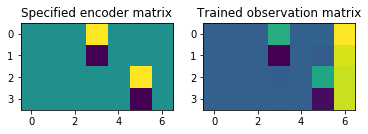

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, a = plt.subplots(1,2)

sim_C = np.zeros((4, 7))
# control x positive directions
sim_C[0, :] = np.array([0, 0, 0, 1, 0, 0, 0])
sim_C[1, :] = np.array([0, 0, 0, -1, 0, 0, 0])
# control z positive directions
sim_C[2, :] = np.array([0, 0, 0, 0, 0, 1, 0])
sim_C[3, :] = np.array([0, 0, 0, 0, 0, -1, 0])
        
a[0].imshow(sim_C)
a[0].set_title('Specified encoder matrix')

a[1].imshow(trained_decoder.filt.C)
a[1].set_title('Trained observation matrix')

# use linear regression to do feature selection

## clearn up the data

In [38]:
print(kin.shape)
#want an easy case, just x y, on the screeen
kin_x_vel = kin[3,:]

kin_x_vel = np.expand_dims(kin_x_vel, axis = 1).T
kin_x_vel.shape

y = kin_x_vel.T
y.shape

(7, 2000)


(2000, 1)

In [39]:
X = spike_counts.T

print(X.shape)

(2000, 4)


## regular ols

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X, y)

lr.coef_


#pred_train_lr= lr.predict(X)
#print(np.sqrt(mean_squared_error(y_train,pred_train_lr)))
#print(r2_score(y_train, pred_train_lr))

array([[ 2.44795628, -2.45350541, -0.11386859,  0.01981317]])

this actually makes sense
because the first two neurons did encode the first dim

control x positive directions
sim_C[0, :] = np.array([0, 0, 0, 1, 0, 0, 0])
sim_C[1, :] = np.array([0, 0, 0, -1, 0, 0, 0])


## ridge regression

In [48]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=0.01)
rr.fit(X, y) 
rr.coef_

array([[ 2.44787933, -2.45342409, -0.11386056,  0.01981366]])

## lasso regression



In [49]:
from sklearn.linear_model import Lasso

model_lasso = Lasso(alpha=0.01)
model_lasso.fit(X, y) 
model_lasso.coef_

array([ 2.3831181 , -2.38689424, -0.0287035 ,  0.        ])